# Self-Attention and Transformers

## Learning Goals

Our goals are to be able to

1. Understand and implement the attention operation
2. Describe how attention can be used to build multiheaded self-attention layers in a network.
3. Understand the purpose of masked attention for building, for example, causal language models
4. Describe how self-attention is used to build Transformer models

## Today's Activity

Our practical goal for this activity is to reimplement a Transformer Layer, using PyTorch's attention implementation as a reference! We'll build up slowly, first reimplementing a method to attention, then a (multi)-headed attention layer, and then a full transformer (decoder) block. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

First, (scaled dot-product) attention! Let's assume for now that we have our query embeddings and our key embeddings for each token in our sequence, each with dimension `seq_len_{query/key}` x `embedding_dim`, and the value vectors, with size `seq_len_key` x `output_dim`. Write a method to compute the attention matrix, which should be of size  `seq_len_query` x `seq_len_key` and from that compute the output representation of size `seq_len_query`x `output_dim`.

Make sure you understand how attention is computed before writing any code!

You may implement this with a for-loop if you'd like, but for **bonus** understanding, the matrix-pilled amongst you should attempt to implement this only using matrix multiplication!

In [ ]:
def my_attention(q : torch.Tensor, k : torch.Tensor, v : torch.Tensor) -> torch.Tensor:
    # TODO
    # Use the querys and keys to compute a weight for each input
    # Get a weighted sum of the values 
    pass

You can verify your implementation by checking against the PyTorch reference implementation:

In [ ]:
q = torch.rand(2,2)
k = torch.rand(2,2)
v = torch.rand(2,3)

theirs = F.scaled_dot_product_attention(q, k, v)
mine = my_attention(q, k, v)

print("q={}\nk={}\nv={} ".format(q, k, v))
print("PyTorch output={}".format(theirs))
print("My output={}".format(mine))
print("Same? {}".format(torch.all(torch.isclose(mine,theirs))))

The next cell runs the test in a loop for a true randomized test of your method!

In [ ]:
num_tests = 100

for i in range(num_tests):
    qk_dim = np.random.randint(1,10)
    v_dim = np.random.randint(1,10)
    seq_len_q = np.random.randint(1,10)
    seq_len_k = np.random.randint(1,10)
  
    q = torch.rand(seq_len_q,qk_dim)
    k = torch.rand(seq_len_k,qk_dim)
    v = torch.rand(seq_len_k,v_dim)

    theirs = F.scaled_dot_product_attention(q, k, v)
    mine = my_attention(q, k, v)
    assert(torch.all(torch.isclose(mine,theirs)))

print("All good (probably)!")

One last thing you should consider is an attention *mask*. For example, we might only want to compute attention over particular tokens. Most notably, we might want to only compute attention over, say, *previous* tokens, so we can build something that looks like the causal language model's we've used before! This is typically implemented by allowing for an attention mask that zeros out certain entries in our attention matrix. 

Crucially, we don't want the mask to change the magnitude of our value, so we'd like to do this *before* the softmax! **What value should you set the masked values to be in order to have them be at or near 0 post-softmax?

`torch.masked_fill_` and the logical operations (i.e., `torch.logical_not`) may be helpful. Play around with them and read the docs so you understand how they work!

Assume the mask is a matrix of booleans!
Implement that below!

In [ ]:
def my_attention(q : torch.Tensor, k : torch.Tensor, v : torch.Tensor, attn_mask : torch.Tensor=None) -> torch.Tensor:
    # TODO
    pass

In [ ]:
q = torch.rand(2,2)
k = torch.rand(2,2)
v = torch.rand(2,3)
mask = torch.ones(2, 2, dtype=torch.bool).tril(diagonal=0)

theirs = F.scaled_dot_product_attention(q, k, v, attn_mask=mask)
mine = my_attention(q, k, v, attn_mask=mask)

print("q={}\nk={}\nv={} ".format(q, k, v))
print("PyTorch output={}".format(theirs))
print("My output={}".format(mine))
print("Same? {}".format(torch.all(torch.isclose(mine,theirs))))

**For completion of this activity, I will be asking that you get the above tests to pass (i.e, have a correct attention implementation!)**

### Making a module
Now, let's build a self-attention layer! This should be a class inheriting from `nn.Module` that stores the query, key, and value embedding matrices. 

1. Implement this first as a *single* head of an attention layer.
3. Allow for *multi*-headed attention.

Here we'll assume that all of our embeddings will lie in a single dimension, called `model_dim` for simplicity (and to match PyTorch defaults!)

In [ ]:
class SelfAttentionHead(nn.Module):
    def __init__(self, model_dim, qk_dim = None):
        super(SelfAttentionHead, self).__init__()
        
        if qk_dim == None: qk_dim = model_dim
        self.model_dim = model_dim
        self.qk_dim = qk_dim
        
        self.Q = nn.Linear(self.model_dim, self.qk_dim)
        self.K = nn.Linear(self.model_dim, self.qk_dim)
        self.V = nn.Linear(self.model_dim, self.model_dim)

    def forward(self, input, mask):
        # TODO
        return None

head = SelfAttentionHead(10)

In [ ]:
class MultiheadedSelfAttention(nn.Module):
    def __init__(self):
        super(MultiheadedSelfAttention, self).__init__()
        #TODO
        pass

    def forward(self, input):
        #TODO 
        pass

mha = MultiheadedSelfAttention()

#### Where are the tests?

To verify your model is build correctly can be tricky, especially with randomly initialized weights!

One option is to compare to `nn.MultiheadedAttention`, but make sure the internal weight matrices are initialized to be the same (which should be a good exercise is understanding the structure of nn.Module objects!), and another --- more common & practical, but less pedagogically useful --- option is to see that both models an train and learn similar solutions. 

A third option is to compare the structure of the computations that are done directly by automatically building a diagram of the computations your model does. I recommend at least checking this out! One option for pytorch is a library called [torchview](https://github.com/mert-kurttutan/torchview), which requires a package called graphviz to be installed both on your machine and on python. This is totally optional, but if you're interested I recommend checking out the link above to verify the models you build match the diagrams I show you!

### The Transformer

If all has gone well up to now, we can build a Transformer (decoder) layer --- the architecture that underlies the GPT models! This consists of a few operations, summarized by this diagram: 

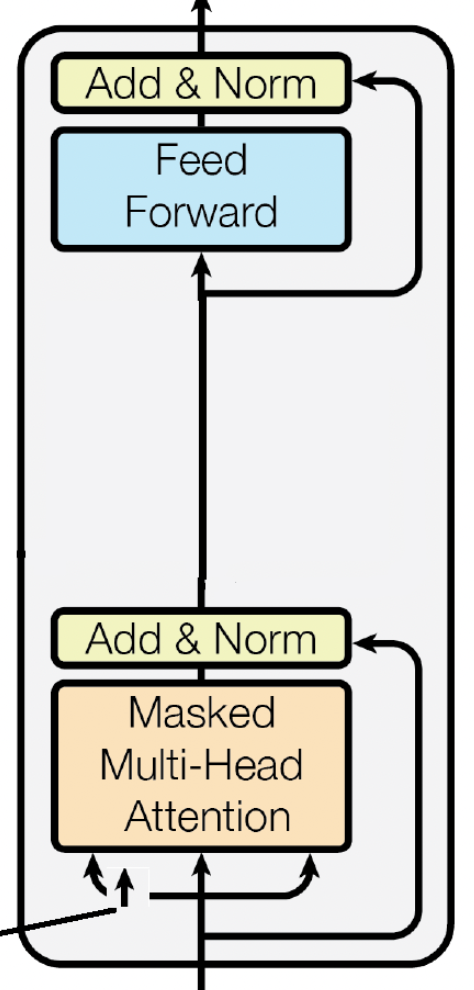

This consists of *causal* masked multiheaded attention (you only attend to tokens to the left!) with a skip connection (i.e., just sum the output with the input!) followed by a feedforward network. Between are some LayerNorms. The core of the transformer models is a stack of these layers feeding into each-other to build *good representations of your input* until the final representation is feed into a logistic regression model to do a task like language modeling.

These are all tools we've introduced!

Ask yourself:

1. What should the dimensions of my input be? What do they **need** to be for the operations to work out?
2. What parameters might I need? What choices could be made when designing the feedforward network? The self-attention?

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self):
        pass

    def forward(self, input):
        pass